In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import os
import rasterio
from shapely.geometry import LineString
import pandas as pd
import rasterio
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiPolygon, MultiLineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
# ---------- Step 1: Elevation querying helper ----------
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from DTM raster at (x, y) location."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# ---------- Step 2: Elevation sampling function ----------
def get_elevation_points_from_lines(dtm_path: str, clipped_gdf, interval: float = 0.01):
    """
    For each point interpolated along lines, fetch elevation from DTM.
    Returns: List of (x, y, z) tuples.
    """
    lines_gdf = clipped_gdf

    with rasterio.open(dtm_path) as dtm_src:
        if lines_gdf.crs != dtm_src.crs:
            print("Reprojecting line geometries to match DTM CRS...")
            lines_gdf = lines_gdf.to_crs(dtm_src.crs)

        points_with_elevation = []

        for geom in lines_gdf.geometry:
            if isinstance(geom, LineString):
                length = geom.length
                num_points = int(length // interval) + 1
                distances = [i * interval for i in range(num_points + 1)]

                for d in distances:
                    pt = geom.interpolate(d)
                    x, y = pt.x, pt.y
                    z = elevation_at_point(dtm_src, x, y)
                    points_with_elevation.append((x, y, z))

        return points_with_elevation
    

def extract_segment_df(intersect_line_path, clipped_line_gdf, dtm1_path, dtm2_path):
    gdf = gpd.read_file(intersect_line_path)
    if gdf.empty:
        return pd.DataFrame()  # Return empty if no data

    if gdf.crs != clipped_line_gdf.crs:
        gdf = gdf.to_crs(clipped_line_gdf.crs)

    main_line = clipped_line_gdf.geometry.iloc[0]
    segment_points = []

    with rasterio.open(dtm1_path) as dtm1, rasterio.open(dtm2_path) as dtm2:
        for seg in gdf.geometry:
            for pt in [seg.interpolate(0), seg.interpolate(seg.length)]:
                chainage = main_line.project(pt)
                elev1 = elevation_at_point(dtm1, pt.x, pt.y)
                elev2 = elevation_at_point(dtm2, pt.x, pt.y)
                segment_points.append({
                    "chainage": chainage,
                    "elevation_itr1": elev1,
                    "elevation_itr2": elev2
                })

    return pd.DataFrame(segment_points)

def plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict, section_name, output_path):
    """
    Plots elevation profiles of two ITRs and intersection zones with vertical dashed lines at intersection points.

    Parameters:
    - df1: DataFrame for ITR1 elevation profile
    - df2: DataFrame for ITR2 elevation profile
    - segment_data_dict: Dictionary of {label: (segment_df, color)}
    - section_name: Section label like "A_A'"
    - output_path: Folder path to save the plot
    """

    import os
    import matplotlib.pyplot as plt

    start_label, end_label = section_name.split("_")
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot base elevation profiles
    ax.plot(df1["chainage"], df1["z"], label="Elevation ITR 1", color="blue", linewidth=1)
    ax.plot(df2["chainage"], df2["z"], label="Elevation ITR 2", color="green", linewidth=1)

    intersection_chainages = []

    for label, (segment_df, color) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue

        # Plot the points
        ax.scatter(segment_df["chainage"], segment_df["elevation_itr1"], color="red", s=10, zorder=5)
        ax.scatter(segment_df["chainage"], segment_df["elevation_itr2"], color="orange", s=10, zorder=5)

        # Collect chainage points for vertical lines
        intersection_chainages.extend(segment_df["chainage"].tolist())

        # Fill areas between elevation lines
        for i in range(0, len(segment_df), 2):
            if i + 1 >= len(segment_df):
                continue

            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])

            mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            x = df1.loc[mask, "chainage"]
            y1 = df1.loc[mask, "z"]
            y2 = df2.loc[mask, "z"]

            ax.fill_between(x, y1, y2, color=color, alpha=0.4, label=label if i == 0 else None)

    # Draw vertical dashed lines at all intersection points
    for x in intersection_chainages:
        ax.axvline(x=x, color='deepskyblue', linestyle='--', linewidth=1)

    # Add section labels
    ax.annotate(start_label, xy=(df1["chainage"].iloc[0], df1["z"].iloc[0]),
                textcoords="offset points", xytext=(-20, 10), fontsize=10, color="blue", weight='bold')
    ax.annotate(end_label, xy=(df1["chainage"].iloc[-1], df1["z"].iloc[-1]),
                textcoords="offset points", xytext=(10, 10), fontsize=10, color="blue", weight='bold')

    ax.set_xlabel("Chainage (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title(f"Elevation vs. Chainage – Section {section_name}")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    # Save plot
    os.makedirs(output_path, exist_ok=True)
    file_path = os.path.join(output_path, f"elevation_plot_{section_name}.png")
    plt.savefig(file_path, dpi=300)
    plt.close()
    print(f"Plot saved to: {file_path}")

    return None

In [6]:
clipped_gdf = gpd.read_file("D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/clipped_lines.shp")

## Dtms
dtm1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
dtm2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_2.tif"

planned_and_done_excavtion_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_planned_and_done_excavation.shp"
unplanned_and_done_excavation_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_unplanned_and_done_excavation.shp"
planned_and_used_dump_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_planned_and_used_dump.shp"
unplanned_and_used_dump_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_unplanned_and_used_dump.shp"


planned_and_done_excavtion = extract_segment_df(planned_and_done_excavtion_lines_path, clipped_gdf, dtm1_path, dtm2_path)
unplanned_and_done_excavation = extract_segment_df(unplanned_and_done_excavation_lines_path , clipped_gdf, dtm1_path, dtm2_path)
planned_and_used_dump = extract_segment_df(planned_and_used_dump_lines_path, clipped_gdf, dtm1_path, dtm2_path)    
unplanned_and_used_dump = extract_segment_df(unplanned_and_used_dump_lines_path, clipped_gdf, dtm1_path, dtm2_path)   



segment_data_dict = {
    "planned_and_done_excavtion": (planned_and_done_excavtion, "green"),
    "unplanned_and_done_excavation":    (unplanned_and_done_excavation, "red"),
    "planned_and_used_dump":  (planned_and_used_dump, "green"),
    "unplanned_and_used_dump": (unplanned_and_used_dump, "red"),  
}

# ---------- Step 2: Get elevation profiles ----------
elevations_itr1 = get_elevation_points_from_lines(dtm1_path, clipped_gdf, interval=0.01)
elevations_itr2 = get_elevation_points_from_lines(dtm2_path, clipped_gdf, interval=0.01)

# ---------- Step 3: Convert to DataFrame ----------
df1 = pd.DataFrame(elevations_itr1, columns=["x", "y", "z"])
df1["chainage"] = [0.01 * i for i in range(len(df1))]

df2 = pd.DataFrame(elevations_itr2, columns=["x", "y", "z"])
df2["chainage"] = [0.01 * i for i in range(len(df2))]


plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict, section_name = "A_A'", output_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_plots")



Plot saved to: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_plots\elevation_plot_A_A'.png


In [28]:
# ---------- Step 1: Elevation querying helper ----------
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from DTM raster at (x, y) location."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# ---------- Step 2: Elevation sampling function ----------
def get_elevation_points_from_lines(dtm_path: str, clipped_line_shapefile: str, interval: float = 0.01):
    """
    For each point interpolated along lines, fetch elevation from DTM.
    Returns: List of (x, y, z) tuples.
    """
    lines_gdf = gpd.read_file(clipped_line_shapefile)

    with rasterio.open(dtm_path) as dtm_src:
        if lines_gdf.crs != dtm_src.crs:
            print("Reprojecting line geometries to match DTM CRS...")
            lines_gdf = lines_gdf.to_crs(dtm_src.crs)

        points_with_elevation = []

        for geom in lines_gdf.geometry:
            if isinstance(geom, LineString):
                length = geom.length
                num_points = int(length // interval) + 1
                distances = [i * interval for i in range(num_points + 1)]

                for d in distances:
                    pt = geom.interpolate(d)
                    x, y = pt.x, pt.y
                    z = elevation_at_point(dtm_src, x, y)
                    points_with_elevation.append((x, y, z))

        return points_with_elevation
    

def plot_elevation_profiles(df1: pd.DataFrame, df2: pd.DataFrame,
                             label1: str = "Elevation ITR 1",
                             label2: str = "Elevation ITR 2",
                             title: str = "Elevation vs. Chainage Comparison",
                             intersection_df: pd.DataFrame = None):
    """
    Plots two elevation profiles with optional intersection points.

    Parameters:
        df1 (pd.DataFrame): DataFrame with columns 'chainage' and 'z' for ITR 1.
        df2 (pd.DataFrame): DataFrame with columns 'chainage' and 'z' for ITR 2.
        label1 (str): Label for the first profile.
        label2 (str): Label for the second profile.
        title (str): Title of the plot.
        intersection_df (pd.DataFrame): Optional DataFrame with 'chainage', 
                                        'elevation_itr1', 'elevation_itr2'.
    """
    plt.figure(figsize=(26, 8))
    plt.plot(df1["chainage"], df1["z"], label=label1, color="blue")
    plt.plot(df2["chainage"], df2["z"], label=label2, color="green")

    if intersection_df is not None:
        # Plot intersection points
        plt.scatter(intersection_df["chainage"], intersection_df["elevation_itr1"],
                    color="red", label="Intersections ITR 1", zorder=5)
        plt.scatter(intersection_df["chainage"], intersection_df["elevation_itr2"],
                    color="orange", label="Intersections ITR 2", zorder=5)

        # Optional: Add labels
        for idx, row in intersection_df.iterrows():
            plt.annotate(f'Pt {idx+1}', (row["chainage"], row["elevation_itr1"]),
                         textcoords="offset points", xytext=(0, 10),
                         ha='center', fontsize=8, color='red')

    plt.xlabel("Chainage (m)")
    plt.ylabel("Elevation (m)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Step 1: Paths ----------
clipped_line_shapefile = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/clipped_line.shp"
dtm1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
dtm2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_2.tif"

# ---------- Step 2: Get elevation profiles ----------
elevations_itr1 = get_elevation_points_from_lines(dtm1_path, clipped_line_shapefile, interval=0.01)
elevations_itr2 = get_elevation_points_from_lines(dtm2_path, clipped_line_shapefile, interval=0.01)

# ---------- Step 3: Convert to DataFrame ----------
df1 = pd.DataFrame(elevations_itr1, columns=["x", "y", "z"])
df1["chainage"] = [0.01 * i for i in range(len(df1))]

df2 = pd.DataFrame(elevations_itr2, columns=["x", "y", "z"])
df2["chainage"] = [0.01 * i for i in range(len(df2))]


# ---------- Step 4: plots  ----------
#plot_elevation_profiles(df1, df2)

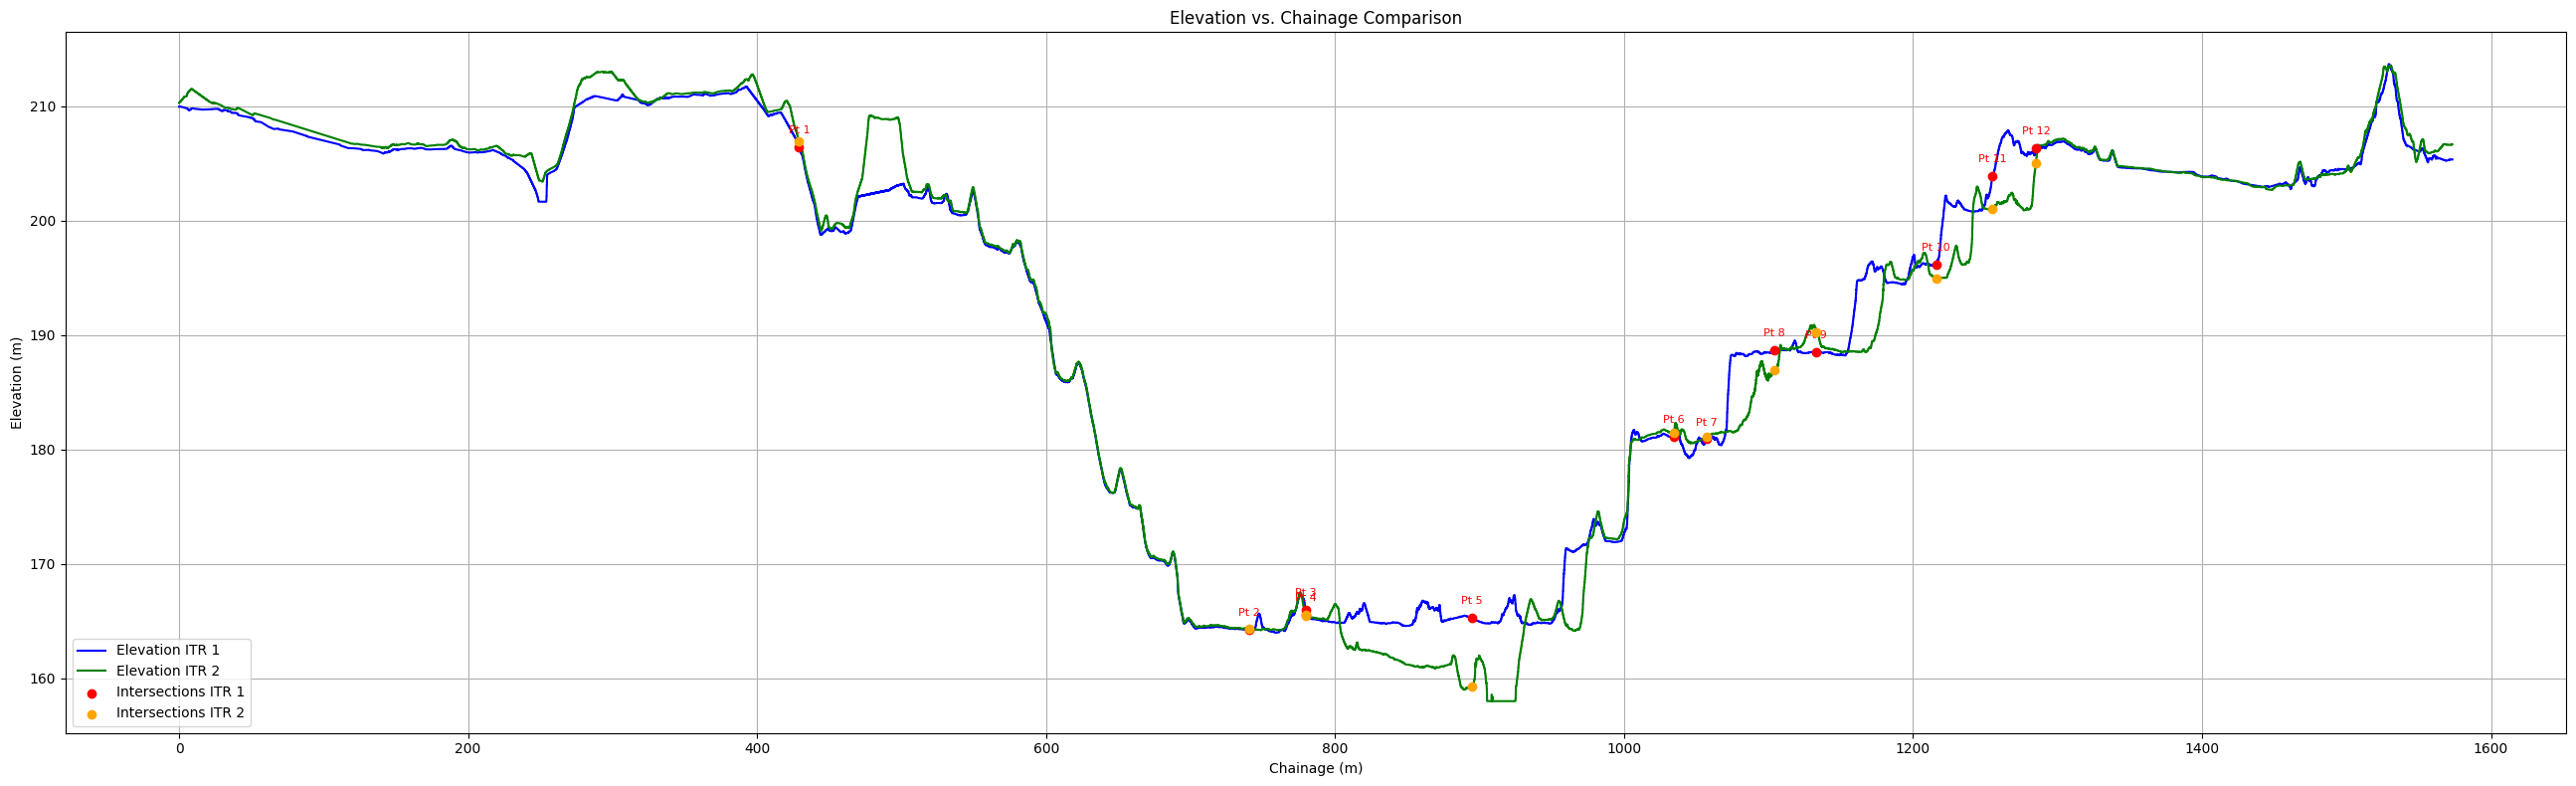

In [29]:
# Path to the intersecting line segments
intersect_line_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/intersecting_segments_unplanned_and_done_excavation.shp"

intersect_seg_gdf = gpd.read_file(intersect_line_path)

# Ensure CRS matches the clipped line
clipped_line_gdf = gpd.read_file(clipped_line_shapefile)
if intersect_seg_gdf.crs != clipped_line_gdf.crs:
    intersect_seg_gdf = intersect_seg_gdf.to_crs(clipped_line_gdf.crs)

# Use the first (or main) line for chainage reference
main_line = clipped_line_gdf.geometry.iloc[0]

segment_points = []

with rasterio.open(dtm1_path) as dtm1, rasterio.open(dtm2_path) as dtm2:
    for seg in intersect_seg_gdf.geometry:
        for pt in [seg.interpolate(0), seg.interpolate(seg.length)]:
            chainage = main_line.project(pt)
            elev1 = elevation_at_point(dtm1, pt.x, pt.y)
            elev2 = elevation_at_point(dtm2, pt.x, pt.y)
            segment_points.append({
                "chainage": chainage,
                "elevation_itr1": elev1,
                "elevation_itr2": elev2
            })

segment_df = pd.DataFrame(segment_points)


plot_elevation_profiles(df1, df2, intersection_df=segment_df)

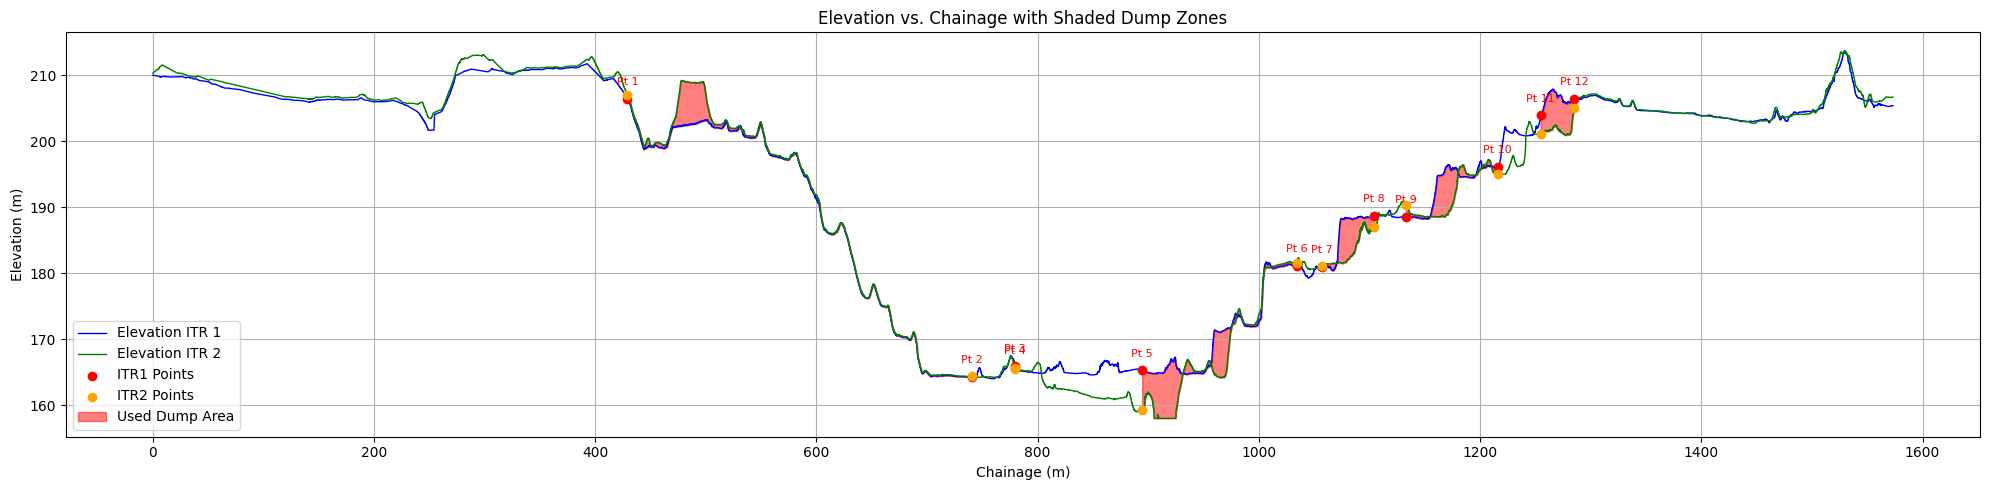

In [30]:
def plot_elevation_profiles_with_shaded_segments(df1, df2, segment_df):
    plt.figure(figsize=(20, 5))

    # Plot ITR 1 and ITR 2 elevation lines
    plt.plot(df1["chainage"], df1["z"], label="Elevation ITR 1", color="blue", linewidth=1)
    plt.plot(df2["chainage"], df2["z"], label="Elevation ITR 2", color="green", linewidth=1)

    # Plot intersection points
    plt.scatter(segment_df["chainage"], segment_df["elevation_itr1"], color="red", label="ITR1 Points", zorder=5)
    plt.scatter(segment_df["chainage"], segment_df["elevation_itr2"], color="orange", label="ITR2 Points", zorder=5)

    # Annotate points
    for idx, row in segment_df.iterrows():
        plt.annotate(f'Pt {idx+1}', (row["chainage"], row["elevation_itr1"]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='red')

    # Shade areas between ITR1 and ITR2 for each segment
    for i in range(0, len(segment_df), 2):  # step = 2 because points come in start/end pairs
        if i+1 >= len(segment_df):  # avoid index out of range
            continue

        ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
        ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])

        # Get slice of data between ch_start and ch_end
        mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
        x = df1.loc[mask, "chainage"]
        y1 = df1.loc[mask, "z"]
        y2 = df2.loc[mask, "z"]

        plt.fill_between(x, y1, y2, color="red", alpha=0.5, label="Used Dump Area" if i == 0 else None)

    plt.xlabel("Chainage (m)")
    plt.ylabel("Elevation (m)")
    plt.title("Elevation vs. Chainage with Shaded Dump Zones")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_elevation_profiles_with_shaded_segments(df1, df2, segment_df)

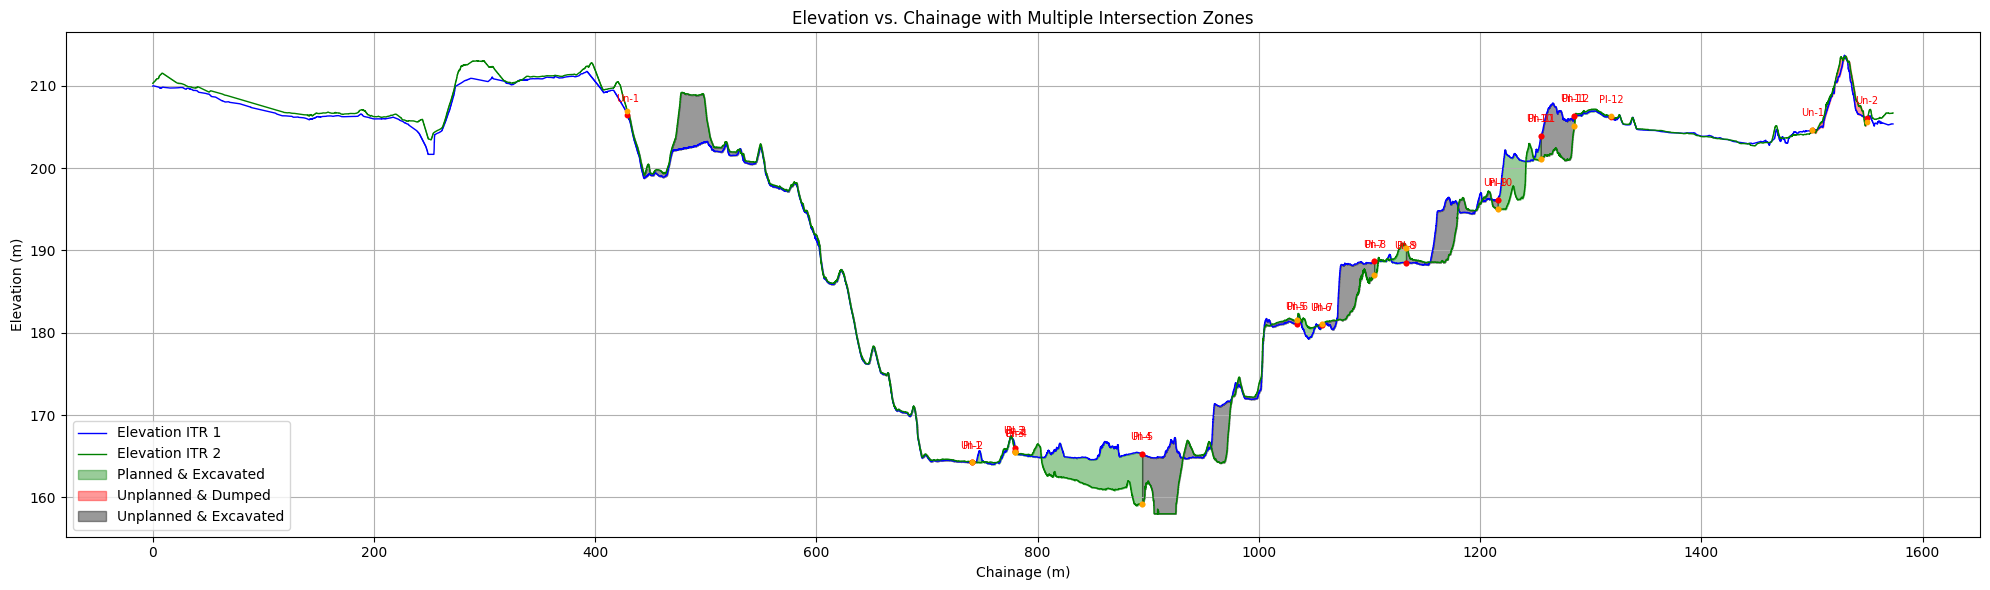

In [ ]:
def plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict):
    """
    df1: DataFrame for ITR1 elevation profile
    df2: DataFrame for ITR2 elevation profile
    segment_data_dict: Dictionary of {label: (segment_df, color)}
    """

    plt.figure(figsize=(20, 6))

    # Base elevation profiles
    plt.plot(df1["chainage"], df1["z"], label="Elevation ITR 1", color="blue", linewidth=1)
    plt.plot(df2["chainage"], df2["z"], label="Elevation ITR 2", color="green", linewidth=1)

    for label, (segment_df, color) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue  # skip empty intersections

        # Plot intersection points
        plt.scatter(segment_df["chainage"], segment_df["elevation_itr1"], color="red", s=10, zorder=5)
        plt.scatter(segment_df["chainage"], segment_df["elevation_itr2"], color="orange", s=10, zorder=5)

        # Annotate points
        for idx, row in segment_df.iterrows():
            plt.annotate(f'{label[:2]}-{idx+1}', (row["chainage"], row["elevation_itr1"]),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='red')

        # Shade regions between ITR1 and ITR2
        for i in range(0, len(segment_df), 2):
            if i+1 >= len(segment_df):
                continue

            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])

            mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            x = df1.loc[mask, "chainage"]
            y1 = df1.loc[mask, "z"]
            y2 = df2.loc[mask, "z"]

            plt.fill_between(x, y1, y2, color=color, alpha=0.4, label=label if i == 0 else None)

    plt.xlabel("Chainage (m)")
    plt.ylabel("Elevation (m)")
    plt.title("Elevation vs. Chainage with Multiple Intersection Zones")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



def extract_segment_df(intersect_line_path, clipped_line_gdf, dtm1_path, dtm2_path):
    gdf = gpd.read_file(intersect_line_path)
    if gdf.empty:
        return pd.DataFrame()  # Return empty if no data

    if gdf.crs != clipped_line_gdf.crs:
        gdf = gdf.to_crs(clipped_line_gdf.crs)

    main_line = clipped_line_gdf.geometry.iloc[0]
    segment_points = []

    with rasterio.open(dtm1_path) as dtm1, rasterio.open(dtm2_path) as dtm2:
        for seg in gdf.geometry:
            for pt in [seg.interpolate(0), seg.interpolate(seg.length)]:
                chainage = main_line.project(pt)
                elev1 = elevation_at_point(dtm1, pt.x, pt.y)
                elev2 = elevation_at_point(dtm2, pt.x, pt.y)
                segment_points.append({
                    "chainage": chainage,
                    "elevation_itr1": elev1,
                    "elevation_itr2": elev2
                })

    return pd.DataFrame(segment_points)



planned_and_done_excavtion_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_planned_and_done_excavation.shp"
unplanned_and_done_excavation_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_unplanned_and_done_excavation.shp"
planned_and_used_dump_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_planned_and_used_dump.shp"
unplanned_and_used_dump_lines_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/output_folder/section_D_D'/section_D_D'_unplanned_and_used_dump.shp"





planned_and_done_excavtion = extract_segment_df(planned_and_done_excavtion_lines_path, clipped_line_gdf, dtm1_path, dtm2_path)
unplanned_and_done_excavation = extract_segment_df(unplanned_and_done_excavation_lines_path , clipped_line_gdf, dtm1_path, dtm2_path)
planned_and_used_dump = extract_segment_df(planned_and_used_dump_lines_path, clipped_line_gdf, dtm1_path, dtm2_path)    
unplanned_and_used_dump = extract_segment_df(unplanned_and_used_dump_lines_path, clipped_line_gdf, dtm1_path, dtm2_path)   



segment_data_dict = {
    "Planned & Excavated": (segment_df_1, "green"),
    "Planned & Dumped":    (segment_df_2, "blue"),
    "Unplanned & Dumped":  (segment_df_4, "red"),
    "Unplanned & Excavated": (segment_df_3, "black"),  # lighter red
}

plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict)


Plot with lines

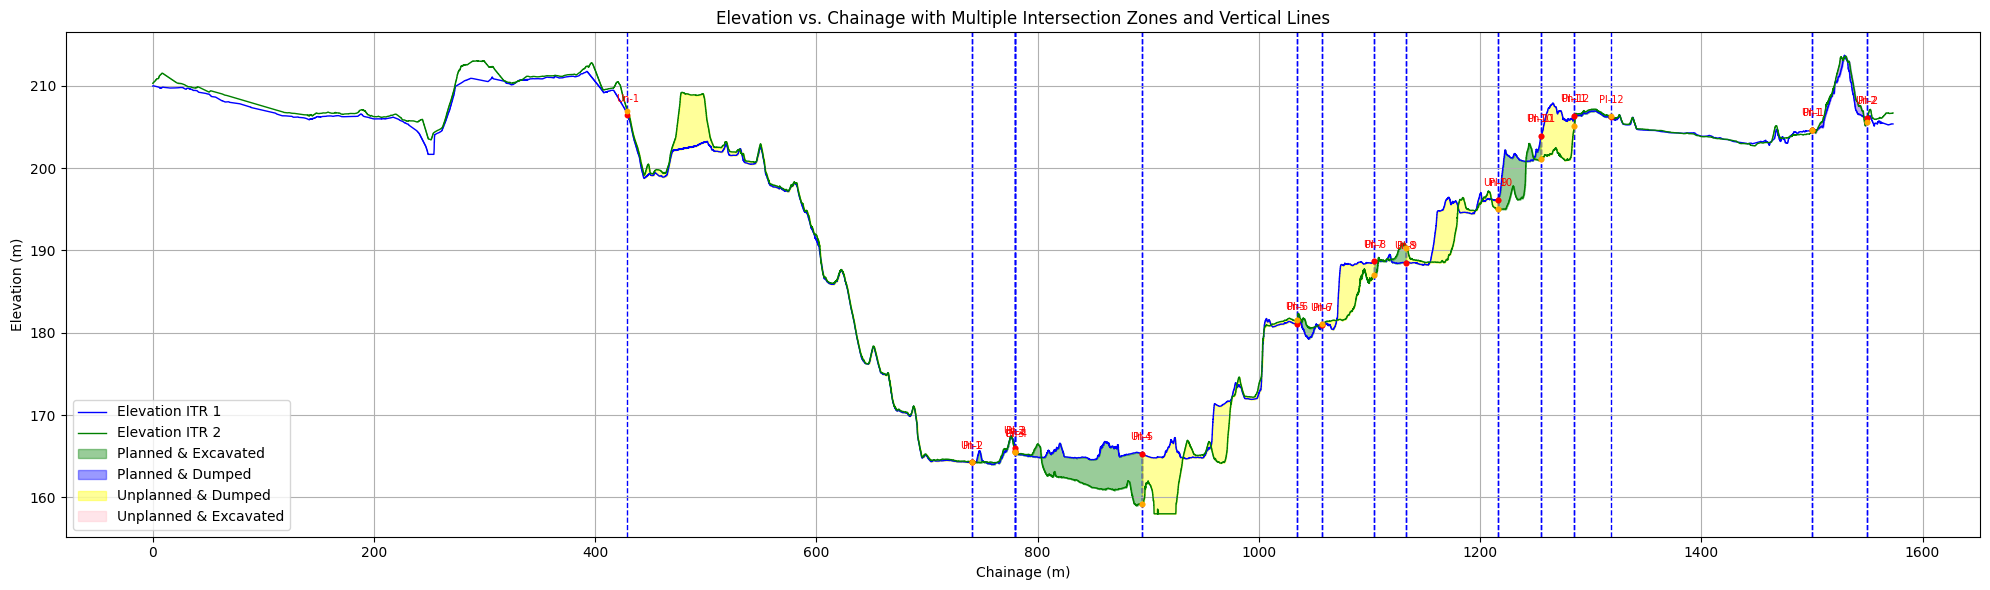

In [41]:
import matplotlib.pyplot as plt

def plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict):
    """
    df1: DataFrame for ITR1 elevation profile
    df2: DataFrame for ITR2 elevation profile
    segment_data_dict: Dictionary of {label: (segment_df, color)}
    """

    plt.figure(figsize=(20, 6))

    # Base elevation profiles
    plt.plot(df1["chainage"], df1["z"], label="Elevation ITR 1", color="blue", linewidth=1)
    plt.plot(df2["chainage"], df2["z"], label="Elevation ITR 2", color="green", linewidth=1)

    for label, (segment_df, color) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue  # skip empty intersections

        # Plot red and orange points
        plt.scatter(segment_df["chainage"], segment_df["elevation_itr1"], color="red", s=10, zorder=5)
        plt.scatter(segment_df["chainage"], segment_df["elevation_itr2"], color="orange", s=10, zorder=5)

        # Annotate points
        for idx, row in segment_df.iterrows():
            plt.annotate(f'{label[:2]}-{idx+1}', (row["chainage"], row["elevation_itr1"]),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='red')

            # Vertical dashed line at each point
            plt.axvline(x=row["chainage"], color="blue", linestyle="--", linewidth=1, zorder=1)

        # Shade regions between ITR1 and ITR2
        for i in range(0, len(segment_df), 2):
            if i+1 >= len(segment_df):
                continue

            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])
            ch_end   = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i+1]["chainage"])

            mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            x = df1.loc[mask, "chainage"]
            y1 = df1.loc[mask, "z"]
            y2 = df2.loc[mask, "z"]

            plt.fill_between(x, y1, y2, color=color, alpha=0.4, label=label if i == 0 else None)

    plt.xlabel("Chainage (m)")
    plt.ylabel("Elevation (m)")
    plt.title("Elevation vs. Chainage with Multiple Intersection Zones and Vertical Lines")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_multiple_intersections_on_elevation(df1, df2, segment_data_dict)


plot into dxf 

In [33]:
import ezdxf
from ezdxf.enums import TextEntityAlignment

def export_elevation_profiles_to_dxf(df1, df2, output_path="elevation_profiles.dxf"):
    doc = ezdxf.new(dxfversion="R2010")
    msp = doc.modelspace()

    # Plot ITR1
    points1 = list(zip(df1["chainage"], df1["z"]))
    msp.add_lwpolyline(points1, dxfattribs={"color": 5})  # blue
    msp.add_text("ITR 1", dxfattribs={"height": 2.5, "color": 5}).set_placement(
        (df1["chainage"].iloc[-1], df1["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Plot ITR2
    points2 = list(zip(df2["chainage"], df2["z"]))
    msp.add_lwpolyline(points2, dxfattribs={"color": 3})  # green
    msp.add_text("ITR 2", dxfattribs={"height": 2.5, "color": 3}).set_placement(
        (df2["chainage"].iloc[-1], df2["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Draw X axis (Chainage)
    x_min, x_max = df1["chainage"].min(), df1["chainage"].max()
    y_min = min(df1["z"].min(), df2["z"].min()) - 5
    msp.add_line((x_min, y_min), (x_max + 10, y_min), dxfattribs={"color": 7})
    msp.add_text("Chainage (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_max + 12, y_min), align=TextEntityAlignment.LEFT
    )

    # Draw Y axis (Elevation)
    y_max = max(df1["z"].max(), df2["z"].max()) + 5
    msp.add_line((x_min, y_min - 5), (x_min, y_max), dxfattribs={"color": 7})
    msp.add_text("Elevation (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_min, y_max + 2), align=TextEntityAlignment.LEFT
    )

    # Save DXF
    doc.saveas(output_path)
    print(f"DXF saved: {output_path}")

export_elevation_profiles_to_dxf(df1, df2, output_path="D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles.dxf")

print(df1)

DXF saved: D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles.dxf
                    x             y           z  chainage
0       306867.489934  2.189054e+06  209.971024      0.00
1       306867.496330  2.189054e+06  209.971024      0.01
2       306867.502727  2.189054e+06  209.971024      0.02
3       306867.509124  2.189054e+06  209.971024      0.03
4       306867.515520  2.189054e+06  209.971024      0.04
...               ...           ...         ...       ...
157324  307873.838717  2.190263e+06  205.360748   1573.24
157325  307873.845114  2.190263e+06  205.360748   1573.25
157326  307873.851511  2.190263e+06  205.360748   1573.26
157327  307873.857907  2.190263e+06  205.360748   1573.27
157328  307873.859454  2.190263e+06  205.360748   1573.28

[157329 rows x 4 columns]


added numbers on dxf file

In [34]:
import ezdxf
from ezdxf.enums import TextEntityAlignment

def export_elevation_profiles_to_dxf(df1, df2, output_path="elevation_profiles.dxf"):
    doc = ezdxf.new(dxfversion="R2010")
    msp = doc.modelspace()

    # Axis range
    x_min, x_max = df1["chainage"].min(), df1["chainage"].max()
    y_min = min(df1["z"].min(), df2["z"].min()) - 5
    y_max = max(df1["z"].max(), df2["z"].max()) + 5

    # Plot ITR1
    points1 = list(zip(df1["chainage"], df1["z"]))
    msp.add_lwpolyline(points1, dxfattribs={"color": 5})  # blue
    msp.add_text("ITR 1", dxfattribs={"height": 2.5, "color": 5}).set_placement(
        (df1["chainage"].iloc[-1], df1["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Plot ITR2
    points2 = list(zip(df2["chainage"], df2["z"]))
    msp.add_lwpolyline(points2, dxfattribs={"color": 3})  # green
    msp.add_text("ITR 2", dxfattribs={"height": 2.5, "color": 3}).set_placement(
        (df2["chainage"].iloc[-1], df2["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Draw X axis
    msp.add_line((x_min, y_min), (x_max + 20, y_min), dxfattribs={"color": 7})
    msp.add_text("Chainage (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_max + 22, y_min), align=TextEntityAlignment.LEFT
    )

    # Draw Y axis
    msp.add_line((x_min, y_min - 5), (x_min, y_max), dxfattribs={"color": 7})
    msp.add_text("Elevation (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_min - 5, y_max + 2), align=TextEntityAlignment.LEFT
    )

    # Add X-axis ticks and labels
    x_interval = 100
    for x in range(int(x_min), int(x_max) + x_interval, x_interval):
        msp.add_line((x, y_min - 1), (x, y_min + 1), dxfattribs={"color": 7})
        msp.add_text(str(x), dxfattribs={"height": 1.5, "color": 7}).set_placement(
            (x, y_min - 3), align=TextEntityAlignment.MIDDLE_CENTER
        )

    # Add Y-axis ticks and labels
    y_interval = 10
    for y in range(int(y_min), int(y_max), y_interval):
        msp.add_line((x_min - 1, y), (x_min + 1, y), dxfattribs={"color": 7})
        msp.add_text(str(y), dxfattribs={"height": 1.5, "color": 7}).set_placement(
            (x_min - 4, y), align=TextEntityAlignment.MIDDLE_RIGHT
        )

    # Add Title
    msp.add_text("Elevation vs. Chainage", dxfattribs={"height": 3, "color": 7}).set_placement(
        ((x_min + x_max) / 2, y_max + 5), align=TextEntityAlignment.MIDDLE_CENTER
    )

    # Add Legend
    legend_x = x_max + 30
    legend_y = y_max

    msp.add_text("Legend:", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (legend_x, legend_y), align=TextEntityAlignment.LEFT
    )
    msp.add_text("Blue Line: Elevation ITR 1", dxfattribs={"height": 2, "color": 5}).set_placement(
        (legend_x, legend_y - 3), align=TextEntityAlignment.LEFT
    )
    msp.add_text("Green Line: Elevation ITR 2", dxfattribs={"height": 2, "color": 3}).set_placement(
        (legend_x, legend_y - 6), align=TextEntityAlignment.LEFT
    )

    # Save DXF
    doc.saveas(output_path)
    print(f"DXF saved: {output_path}")



export_elevation_profiles_to_dxf(df1, df2, output_path="D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles_new.dxf")

DXF saved: D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles_new.dxf


Add fill area in dxf file

In [43]:
import ezdxf
from ezdxf.enums import TextEntityAlignment
from ezdxf.math import Vec2


def export_elevation_profiles_to_dxf_with_fill(df1, df2, segment_data_dict, output_path="elevation_profiles.dxf"):
    doc = ezdxf.new(dxfversion="R2010")
    msp = doc.modelspace()

    # Plot ITR1
    points1 = list(zip(df1["chainage"], df1["z"]))
    msp.add_lwpolyline(points1, dxfattribs={"color": 5})  # blue
    msp.add_text("ITR 1", dxfattribs={"height": 2.5, "color": 5}).set_placement(
        (df1["chainage"].iloc[-1], df1["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Plot ITR2
    points2 = list(zip(df2["chainage"], df2["z"]))
    msp.add_lwpolyline(points2, dxfattribs={"color": 3})  # green
    msp.add_text("ITR 2", dxfattribs={"height": 2.5, "color": 3}).set_placement(
        (df2["chainage"].iloc[-1], df2["z"].iloc[-1]), align=TextEntityAlignment.LEFT
    )

    # Draw X and Y axes
    x_min, x_max = df1["chainage"].min(), df1["chainage"].max()
    y_min = min(df1["z"].min(), df2["z"].min()) - 5
    y_max = max(df1["z"].max(), df2["z"].max()) + 5

    msp.add_line((x_min, y_min), (x_max + 10, y_min), dxfattribs={"color": 7})
    msp.add_text("Chainage (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_max + 12, y_min), align=TextEntityAlignment.LEFT
    )
    msp.add_line((x_min, y_min - 5), (x_min, y_max), dxfattribs={"color": 7})
    msp.add_text("Elevation (m)", dxfattribs={"height": 2.5, "color": 7}).set_placement(
        (x_min, y_max + 2), align=TextEntityAlignment.LEFT
    )

    # Fill zones between ITR1 and ITR2 based on segment_data_dict
    for label, (segment_df, color) in segment_data_dict.items():
        if segment_df is None or segment_df.empty:
            continue

        for i in range(0, len(segment_df), 2):
            if i + 1 >= len(segment_df):
                continue

            ch_start = min(segment_df.iloc[i]["chainage"], segment_df.iloc[i + 1]["chainage"])
            ch_end = max(segment_df.iloc[i]["chainage"], segment_df.iloc[i + 1]["chainage"])

            # Filter chainage range from df1 and df2
            mask = (df1["chainage"] >= ch_start) & (df1["chainage"] <= ch_end)
            x = df1.loc[mask, "chainage"].values
            y1 = df1.loc[mask, "z"].values
            y2 = df2.loc[mask, "z"].values

            if len(x) < 2:
                continue

            # Build polygon: ITR1 forward + ITR2 reverse
            polygon_points = [Vec2(c, z) for c, z in zip(x, y1)] + [Vec2(c, z) for c, z in zip(x[::-1], y2[::-1])]

            # Create hatch with solid fill
            hatch = msp.add_hatch(color=6)  # default color
            path = hatch.paths.add_polyline_path(polygon_points, is_closed=True)

    # Save the DXF
    doc.saveas(output_path)
    print(f"DXF saved with fills: {output_path}")


export_elevation_profiles_to_dxf_with_fill(df1, df2, segment_data_dict,
                                           output_path="D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles_with_fill_new.dxf")

DXF saved with fills: D:/2_Analytics/6_plan_vs_actual/line_shp_file/elevation_profiles_with_fill_new.dxf
